In [1]:
from utils import *
from q_learning import *
import time
import pickle

In [2]:
# Configurations
save_stats = False
save_figs = True
load = True

## 2. Q-Learning

In [3]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000

### 2.1 Learning from experts

In [4]:
epsilon_vec_plot = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))

In [5]:
if not load:
    env = TictactoeEnv()
    stats_dict_eps = {}
    for epsilon in epsilon_vec:
        print("------------- Training with epsilon =", epsilon, "-------------")
        start = time.time()
        Q, stats = q_learning(env, num_episodes=num_episodes,
                              epsilon_exploration=epsilon, test_freq=250, verbose=False, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_eps.update({epsilon: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with epsilon =", epsilon, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_eps.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_eps, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon = 0.0 : 	M_opt =  0.0 	M_rand =  0.896
epsilon = 0.0001 : 	M_opt =  0.0 	M_rand =  0.911
epsilon = 0.0005 : 	M_opt =  0.0 	M_rand =  0.863
epsilon = 0.001 : 	M_opt =  0.0 	M_rand =  0.884
epsilon = 0.005 : 	M_opt =  0.0 	M_rand =  0.8915
epsilon = 0.01 : 	M_opt =  0.0 	M_rand =  0.8245
epsilon = 0.05 : 	M_opt =  0.0 	M_rand =  0.833
epsilon = 0.1 : 	M_opt =  -0.189 	M_rand =  0.7245
epsilon = 0.5 : 	M_opt =  -0.392 	M_rand =  0.652
epsilon = 1.0 : 	M_opt =  -0.281 	M_rand =  0.629


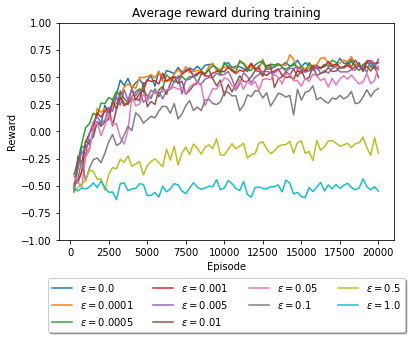

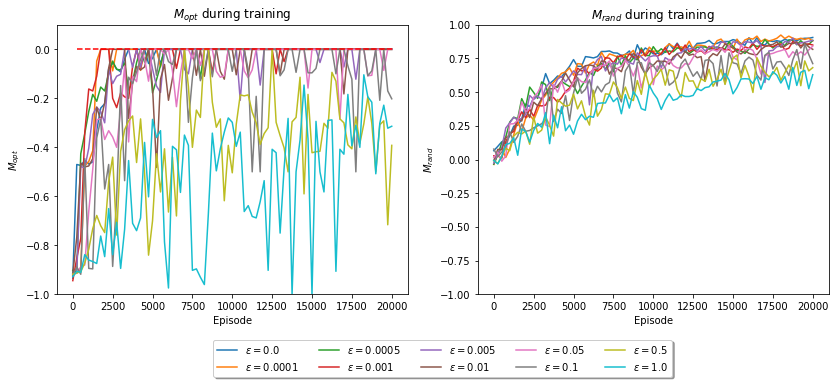

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps = pickle.load(handle)

plot_stats(stats_dict_eps, epsilon_vec_plot, "epsilon", "\epsilon", save=True)

#### Question 1: Average reward with $\epsilon = 0.1$

In [7]:
epsilon_exploration = 0.1
Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=False, against_opt=True)

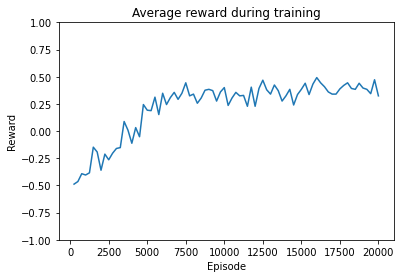


----- Trained  player-----
M_opt =  0.0
M_rand =  0.754
M_teacher =  0.532

----- Optimal  player-----
M_opt =  0.0
M_rand =  0.92
M_teacher =  0.636

----- Random  player-----
M_opt =  -0.928
M_rand =  0.058
M_teacher =  -0.552


In [8]:
# Plotting the average reward for every 250 games during training
running_average_rewards, x = running_average(stats['rewards'])
fig = plt.figure()
plt.plot(x, running_average_rewards)
plt.ylim([-1,1])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average reward during training')
plt.show()
if save_figs:
        output_folder = os.path.join(os.getcwd(), 'figures')
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + '/rewards_Q1.png')
        fig.savefig(output_folder + '/rewards_Q1.eps', format = 'eps')

# Comparing the performance with the optimal player and the random player
turns = np.array(['X','O'])
player_opt = OptimalPlayer(epsilon=0.)
player_rand = OptimalPlayer(epsilon=1.)
teacher = OptimalPlayer(epsilon=0.5)

names = ['Trained', 'Optimal', 'Random']
players = [QPlayer(Q=Q), OptimalPlayer(epsilon=0.), OptimalPlayer(epsilon=1.)]

for (name, player) in zip(names, players):
    print("\n-----", name, " player-----")
    m_opt = measure_performance(player, player_opt)
    print("M_opt = ", m_opt)
    m_rand = measure_performance(player, player_rand)
    print("M_rand = ", m_rand)
    m_teacher = measure_performance(player, teacher)
    print("M_teacher = ", m_teacher)

#### Questions 2 and 3: Decreasing exploration for different values of $n^{*}$

In [9]:
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [10]:
if not load:
    stats_dict_nstar = {}
    for n_star in vec_n_star:
        print("------------- Training with n_star =", n_star, "-------------")
        def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, test_freq=test_freq, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_nstar.update({n_star: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with n_star =", n_star, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star_first = 1.0 : 	M_opt =  0.0 	M_rand =  0.6875
n_star_first = 24460.0 : 	M_opt =  -0.0915 	M_rand =  0.754
n_star_first = 40000 : 	M_opt =  0.0 	M_rand =  0.7325


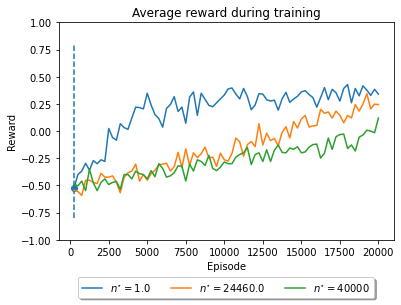

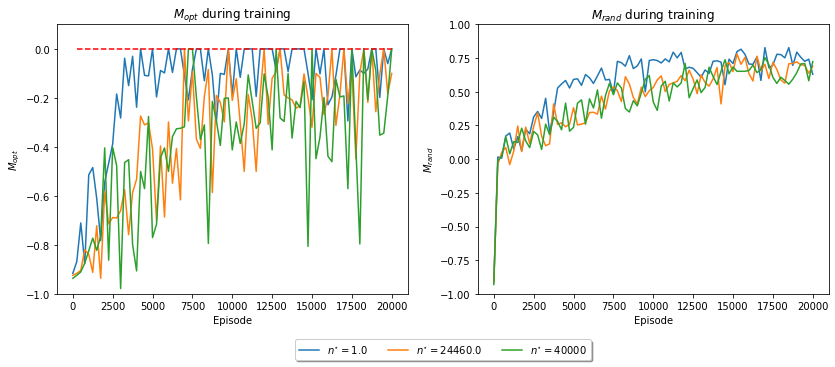

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


n_star_second = 1.0 : 	M_opt =  0.0 	M_rand =  0.6875
n_star_second = 4373.0 : 	M_opt =  0.0 	M_rand =  0.7895
n_star_second = 9146.0 : 	M_opt =  0.0 	M_rand =  0.7965


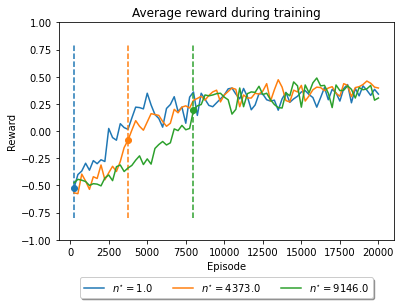

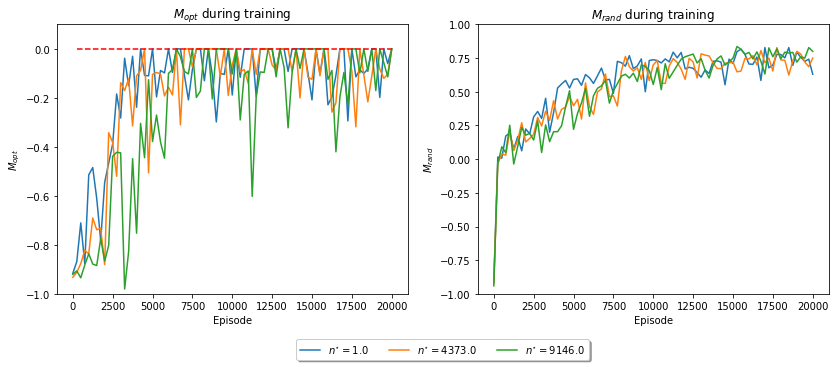

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar = pickle.load(handle)

plot_n_star = [1., 24460., 40000]
plot_stats(stats_dict_nstar, plot_n_star, 'n_star_first', "n^{\star}", save=True, decaying_exploration=True)

plot_n_star = [1., 4373., 9146.]
plot_stats(stats_dict_nstar, plot_n_star, 'n_star_second', "n^{\star}", save=True, decaying_exploration=True)
# plot_stats(stats_dict_nstar, vec_n_star, 'n_star', "n^{\star}", save=False)

#### Questions 4 and 5: Good experts and bad experts

In [12]:
n_star = 4000 # this should be picked from before not inserted manually
M = 11
vec_epsilon_opt = np.linspace(0, 1, M)

In [13]:
if not load:
    stats_dict_epsilon_opt = {}
    for epsilon_opt in vec_epsilon_opt:
        print("------------- Training with epsilon_opt =", epsilon_opt, "-------------")
        start = time.time()
        Q, stats = q_learning(env, epsilon_opt=epsilon_opt, test_freq=test_freq, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_epsilon_opt.update({epsilon_opt: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with epsilon_opt =", epsilon_opt, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_epsilon_opt.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_epsilon_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon_opt = 0.0 : 	M_opt =  0.0 	M_rand =  0.191
epsilon_opt = 0.5 : 	M_opt =  -0.098 	M_rand =  0.711
epsilon_opt = 1.0 : 	M_opt =  -0.264 	M_rand =  0.828


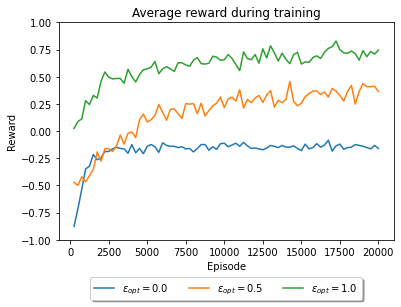

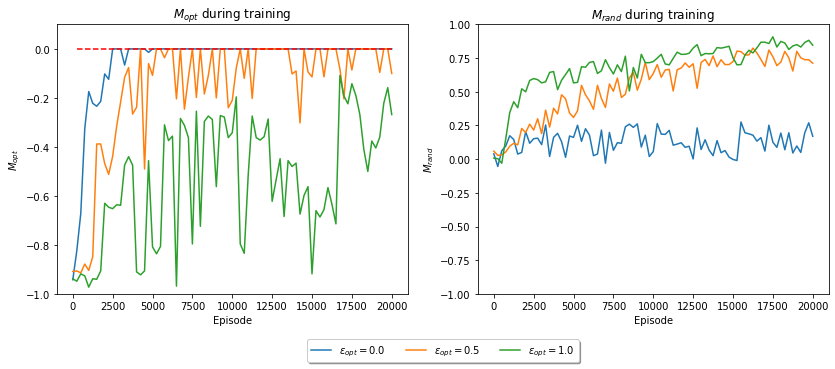

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [14]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_epsilon_opt = pickle.load(handle)

plot_epsilon_opt = [0., 0.5, 1.]
plot_stats(stats_dict_epsilon_opt, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=True)
# plot_stats(stats_dict_epsilon_opt, vec_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=False)

### 2.2 Learning by self-practice

#### Question 7: Self-learning with constant rate of exploration $\epsilon$

In [15]:
epsilon_vec_plot = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))

In [16]:
if not load:
    env = TictactoeEnv()
    stats_dict_eps_self = {}
    for epsilon in epsilon_vec:
        print("------------- Training with epsilon =", epsilon, "-------------")
        Q, stats = q_learning(env, num_episodes=num_episodes,
                            epsilon_exploration=epsilon, test_freq = 250, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_eps_self.update({epsilon: (stats, M_opt, M_rand)})

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_eps_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_eps_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon_self = 0 : 	M_opt =  -0.7505 	M_rand =  0.2285
epsilon_self = 0.005 : 	M_opt =  -0.191 	M_rand =  0.683
epsilon_self = 0.1 : 	M_opt =  0.0 	M_rand =  0.919
epsilon_self = 0.5 : 	M_opt =  -0.3065 	M_rand =  0.726


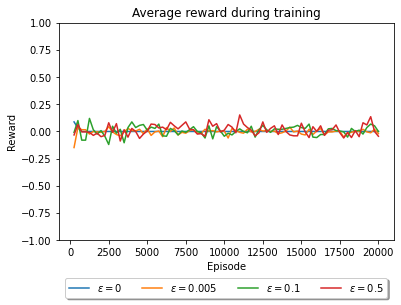

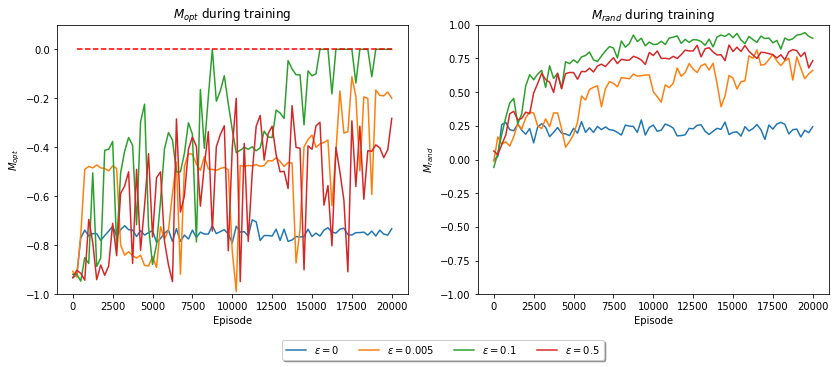

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


epsilon_self = 0.0 : 	M_opt =  -0.7505 	M_rand =  0.2285
epsilon_self = 0.0001 : 	M_opt =  -0.9285 	M_rand =  0.387
epsilon_self = 0.0005 : 	M_opt =  -0.6435 	M_rand =  0.4165
epsilon_self = 0.001 : 	M_opt =  -0.4875 	M_rand =  0.4275
epsilon_self = 0.005 : 	M_opt =  -0.191 	M_rand =  0.683
epsilon_self = 0.01 : 	M_opt =  -0.148 	M_rand =  0.8135
epsilon_self = 0.05 : 	M_opt =  -0.103 	M_rand =  0.928
epsilon_self = 0.1 : 	M_opt =  0.0 	M_rand =  0.919
epsilon_self = 0.5 : 	M_opt =  -0.3065 	M_rand =  0.726
epsilon_self = 1.0 : 	M_opt =  -0.9045 	M_rand =  0.5325
epsilon_self = 0.00021544346900318845 : 	M_opt =  -0.481 	M_rand =  0.3945
epsilon_self = 0.00046415888336127773 : 	M_opt =  -0.4855 	M_rand =  0.3995
epsilon_self = 0.002154434690031882 : 	M_opt =  -0.8455 	M_rand =  0.5495
epsilon_self = 0.004641588833612777 : 	M_opt =  -0.277 	M_rand =  0.622
epsilon_self = 0.021544346900318822 : 	M_opt =  0.0 	M_rand =  0.8455
epsilon_self = 0.046415888336127774 : 	M_opt =  -0.191 	M_rand 

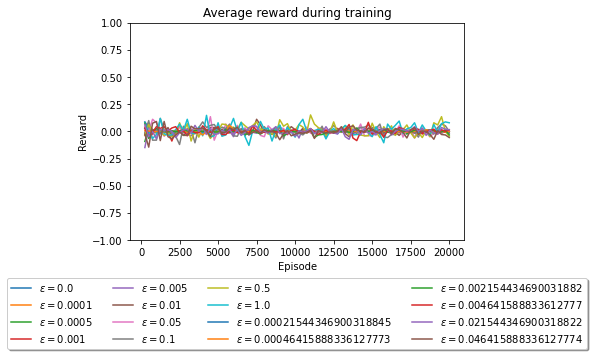

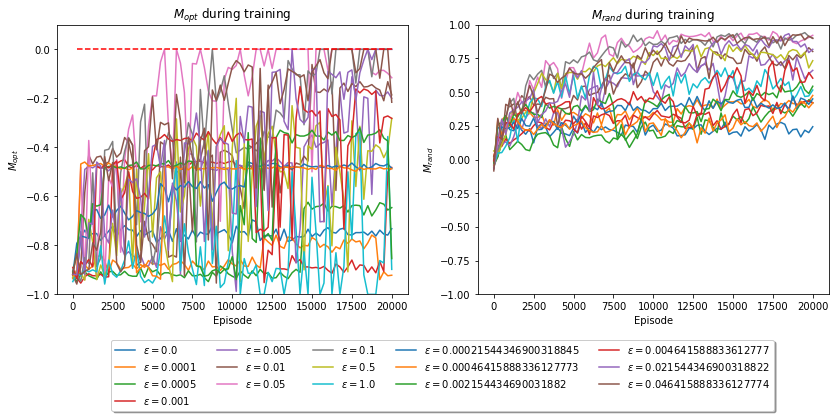

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_self = pickle.load(handle)

epsilon_vec_plot = [0, 0.005, 0.1, 0.5]
plot_stats(stats_dict_eps_self, epsilon_vec_plot, "epsilon_self", "\epsilon", save=save_figs)
plot_stats(stats_dict_eps_self, epsilon_vec, "epsilon_self", "\epsilon", save=save_figs)

#### Question 8: Decaying exploration rule for different values of $n^*$

In [18]:
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
epsilon_min = 0.1
epsilon_max = 0.8

In [19]:
if not load:
    stats_dict_nstar_self = {}
    for n_star in vec_n_star:
        print("------------- Training with n_star =", n_star, "-------------")
        def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule,
                                test_freq=test_freq,  num_episodes=num_episodes, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=200)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=200)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_nstar_self.update({n_star: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with n_star =", n_star, "took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.875
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star = 24460.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star = 40000 : 	M_opt =  -0.555 	M_rand =  0.8


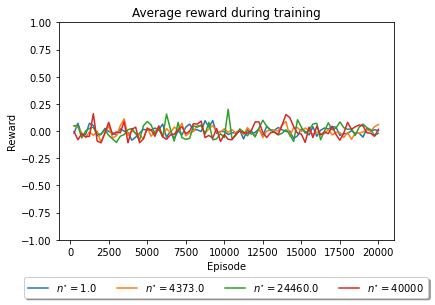

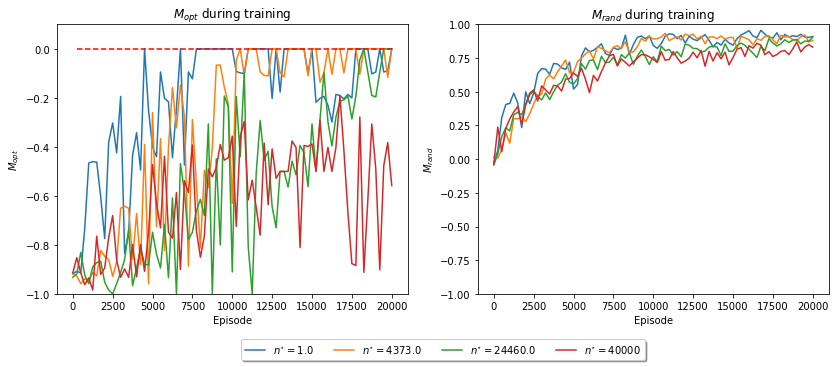

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.875
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star = 9146.0 : 	M_opt =  0.0 	M_rand =  0.92


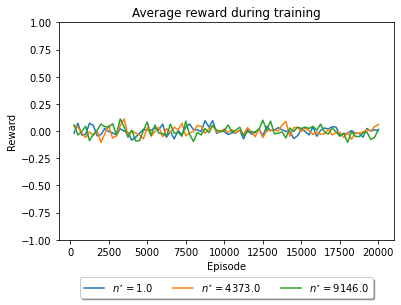

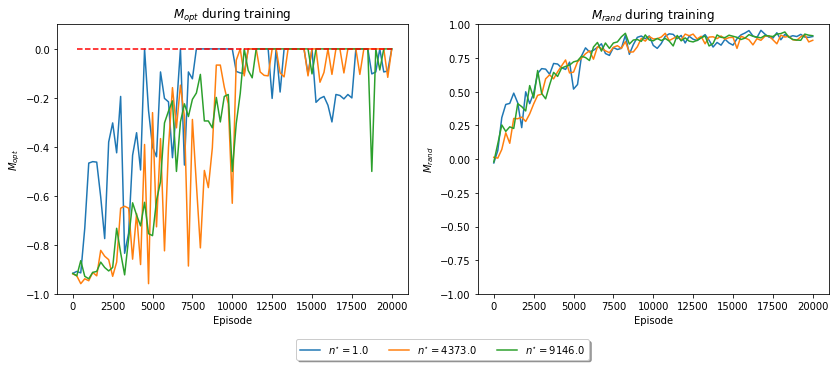

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.875
n_star = 100.0 : 	M_opt =  0.0 	M_rand =  0.91
n_star = 500.0 : 	M_opt =  0.0 	M_rand =  0.85
n_star = 750.0 : 	M_opt =  0.0 	M_rand =  0.955
n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.935
n_star = 1279.0 : 	M_opt =  0.0 	M_rand =  0.88
n_star = 1635.0 : 	M_opt =  -0.12 	M_rand =  0.88
n_star = 2091.0 : 	M_opt =  0.0 	M_rand =  0.855
n_star = 2674.0 : 	M_opt =  -0.09 	M_rand =  0.92
n_star = 3420.0 : 	M_opt =  -0.09 	M_rand =  0.87
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star = 5593.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star = 7152.0 : 	M_opt =  0.0 	M_rand =  0.88
n_star = 9146.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star = 11696.0 : 	M_opt =  -0.085 	M_rand =  0.94
n_star = 14957.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star = 19127.0 : 	M_opt =  -0.245 	M_rand =  0.885
n_star = 24460.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star = 31279.0 : 	M_opt =  -0.315 	M_rand =  0.87
n_star = 40000.0 : 	M_opt =  -0.555 	M_rand =  0.8


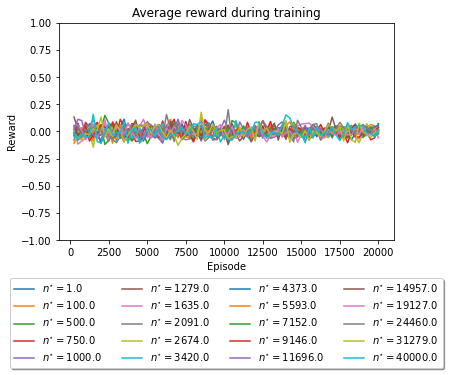

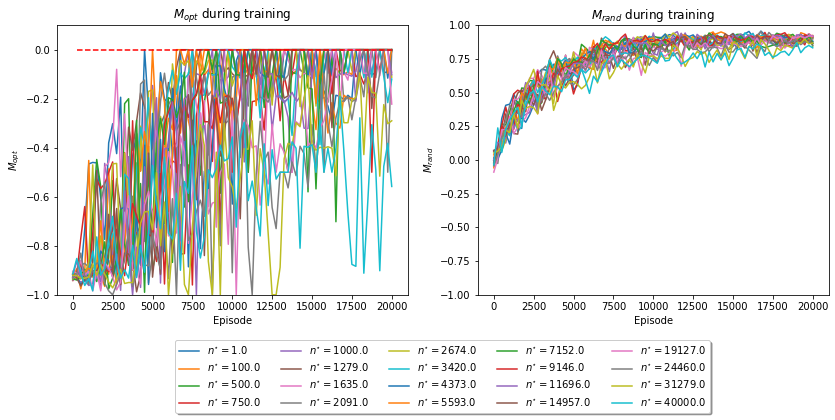

In [20]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_self = pickle.load(handle)

plot_n_star = [1., 4373., 24460., 40000]
plot_stats(stats_dict_nstar_self, plot_n_star, 'n_star', "n^{\star}", save=save_figs)

plot_n_star = [1., 4373., 9146.]
plot_stats(stats_dict_nstar_self, plot_n_star, 'n_star', "n^{\star}", save=save_figs)
plot_stats(stats_dict_nstar_self, vec_n_star, 'n_star', "n^{\star}", save=False)

#### Question 10: Heatmaps of the Q-values in 3 significant states

In [21]:
# Parametri ottimali di Q
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 4373
def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, num_episodes=20000, verbose=True, self_practice=True)

In [22]:
grids = [[1., 0., 0., -1., 1., 0., 0., -1., 0.], [-1., 0., 0., 1., 0., 0., 0., 1., -1.], [1., -1., 0., 0., 0., 0., 0., 0., 0.]]
heatmaps_subplots(grids, Q)

C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 2 x 2 in image.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: C:\Users\Federico Betti\Documents\Artificial Neural Networks\ANN_Project\code\figures/heatmap_0.png
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 2 x 2 in image.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: C:\Users\Federico Betti\Documents\Artificial Neural Networks\ANN_Project\code\figures/heatmap_0.eps
C:\U

## Deep Q-Learning